## Data Import

In [3]:
# Feature Adoption (Beta) → Business Metrics
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

ACCOUNTS = "data/ravenstack_accounts.csv"
SUBS     = "data/ravenstack_subscriptions.csv"
USAGE    = "data/ravenstack_feature_usage.csv"
SUPPORT  = "data/ravenstack_support_tickets.csv"
CHURN    = "data/ravenstack_churn_events.csv"

accounts = pd.read_csv(ACCOUNTS, parse_dates=["signup_date"])
subs     = pd.read_csv(SUBS,     parse_dates=["start_date","end_date"])
usage    = pd.read_csv(USAGE,    parse_dates=["usage_date"])
support  = pd.read_csv(SUPPORT,  parse_dates=["submitted_at","closed_at"])
churn    = pd.read_csv(CHURN,    parse_dates=["churn_date"])


## Build 90-day window and aggregates

In [4]:
# Attach account_id to usage
usage = usage.merge(subs[["subscription_id","account_id"]].drop_duplicates(),
                    on="subscription_id", how="left")

# Analysis window: last 90 days in the data
global_end = max(
    usage["usage_date"].max(),
    support["submitted_at"].max(),
    subs["end_date"].fillna(subs["start_date"].max()).max(),
    churn["churn_date"].max()
)
window_start = global_end - pd.Timedelta(days=90)

# Filter
u90  = usage[(usage["usage_date"] >= window_start) & (usage["usage_date"] <= global_end)].copy()
s90  = support[(support["submitted_at"] >= window_start) & (support["submitted_at"] <= global_end)].copy()
sub90 = subs.copy()
sub90["end_date"] = sub90["end_date"].fillna(global_end)

# Usage aggregates (90d)
u90["events_beta"] = np.where(u90["is_beta_feature"], u90["usage_count"], 0)

# Distinct days with any beta usage in the window
beta_by_day = (u90[u90["is_beta_feature"]]
               .assign(day=lambda d: d["usage_date"].dt.date)
               .groupby(["account_id","day"]).size().reset_index(name="n"))
beta_days = beta_by_day.groupby("account_id")["day"].nunique().rename("beta_days")

agg_u = (u90.groupby("account_id")
           .agg(events_all=("usage_count","sum"),
                duration_secs=("usage_duration_secs","sum"),
                errors=("error_count","sum"),
                beta_events=("events_beta","sum"),
                features_used=("feature_name","nunique"))
           .reset_index()
           .merge(beta_days, on="account_id", how="left"))
agg_u["beta_days"] = agg_u["beta_days"].fillna(0)

# Recency of beta (relative to global_end, using full usage)
last_beta = (usage[usage["is_beta_feature"]]
             .groupby("account_id")["usage_date"].max()
             .rename("last_beta_date"))
agg_u = agg_u.merge(last_beta, on="account_id", how="left")
agg_u["days_since_beta"] = (global_end - agg_u["last_beta_date"]).dt.days


## Support and subscription snapshots

In [5]:
def is_high(p): 
    return str(p).lower() in ("high","urgent","p1","critical")

s90["is_high"] = s90["priority"].apply(is_high)
agg_sup = (s90.groupby("account_id")
             .agg(tickets=("ticket_id","count"),
                  high_tickets=("is_high","sum"),
                  avg_csat=("satisfaction_score","mean"),
                  sla_breaches=("resolution_time_hours", lambda s: (s>24).sum()))
             .reset_index())

# Latest subscription record overlapping the window
sub90_in = sub90[(sub90["start_date"] <= global_end) & (sub90["end_date"] >= window_start)].copy()
sub90_in = sub90_in.sort_values(["account_id","end_date"])
latest_sub = (sub90_in.groupby("account_id", as_index=False)
                       .tail(1)[["account_id","plan_tier","seats","mrr_amount",
                                "upgrade_flag","downgrade_flag","is_trial"]])


## Combine, define adoption, compute correlations & group deltas

In [6]:
# Churn label: churn within 90d AFTER the window (may be all zeros in this dataset window)
first_churn = churn.groupby("account_id")["churn_date"].min()
label_next90 = (first_churn[(first_churn > global_end) & (first_churn <= global_end + pd.Timedelta(days=90))]
                .reset_index()
                .assign(churn_next_90d=1))
label_next90 = label_next90.set_index("account_id")["churn_next_90d"]

df = (accounts[["account_id","industry","country","referral_source"]]
      .merge(agg_u, on="account_id", how="left")
      .merge(agg_sup, on="account_id", how="left")
      .merge(latest_sub, on="account_id", how="left"))

# Fill
for c in ["events_all","duration_secs","errors","beta_events","beta_days",
          "features_used","tickets","high_tickets","sla_breaches",
          "mrr_amount","seats","upgrade_flag","downgrade_flag"]:
    df[c] = df[c].fillna(0)

# Adoption metrics
df["beta_share_90d"] = df["beta_events"] / np.maximum(df["events_all"], 1)
df["beta_adopter"]   = ((df["beta_share_90d"] >= 0.05) | (df["beta_days"] >= 3)).astype(int)
df["recent_beta_14d"]= (df["days_since_beta"] <= 14).fillna(False).astype(int)
df["churn_next_90d"] = df["account_id"].map(label_next90).fillna(0).astype(int)

# Correlations (Spearman)
metrics = ["mrr_amount","seats","upgrade_flag","downgrade_flag","tickets","high_tickets",
           "sla_breaches","duration_secs","errors","features_used","churn_next_90d"]
adopt_vars = ["beta_share_90d","beta_days","recent_beta_14d"]

rows = []
for a in adopt_vars:
    for m in metrics:
        s = df[[a, m]].dropna()
        if len(s) > 3:
            rho = s[a].corr(s[m], method="spearman")
            rows.append({"adoption_metric": a, "business_metric": m, "spearman_r": rho, "n": len(s)})
corr = pd.DataFrame(rows).sort_values(["adoption_metric","spearman_r"], ascending=[True, False])
corr.head(12)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]


,adoption_metric,business_metric,spearman_r,n
20,beta_days,features_used,0.378143,500
18,beta_days,duration_secs,0.341354,500
19,beta_days,errors,0.195412,500
13,beta_days,upgrade_flag,0.099770,500
17,beta_days,sla_breaches,0.076510,500
16,beta_days,high_tickets,0.051945,500
11,beta_days,mrr_amount,0.048675,500
15,beta_days,tickets,0.038756,500
12,beta_days,seats,-0.005284,500
14,beta_days,downgrade_flag,-0.007767,500


## Adopters vs non-adopters summary

In [7]:
grouped = (df.groupby("beta_adopter")
             .agg(accounts=("account_id","nunique"),
                  avg_mrr=("mrr_amount","mean"),
                  avg_seats=("seats","mean"),
                  upgrade_rate=("upgrade_flag","mean"),
                  downgrade_rate=("downgrade_flag","mean"),
                  tickets=("tickets","mean"),
                  high_tickets=("high_tickets","mean"),
                  sla_breaches=("sla_breaches","mean"),
                  churn_next_90d=("churn_next_90d","mean"),
                  recent_beta_14d=("recent_beta_14d","mean"))
             .reset_index())
grouped


,beta_adopter,accounts,avg_mrr,avg_seats,upgrade_rate,downgrade_rate,tickets,high_tickets,sla_breaches,churn_next_90d,recent_beta_14d
0,0,269,2137.747212,29.159851,0.081784,0.033457,0.483271,0.241636,0.278810,0.0,0.003717
1,1,231,2431.714286,29.718615,0.138528,0.034632,0.597403,0.307359,0.411255,0.0,0.207792


## Simple churn model just to check signal

In [11]:
corr = pd.DataFrame(rows).sort_values(["adoption_metric","spearman_r"], ascending=[True, False])
print(
    corr.assign(abs_r=lambda d: d["spearman_r"].abs())
        .sort_values("abs_r", ascending=False)
        .head(10)[["adoption_metric","business_metric","spearman_r","n"]]
)


    adoption_metric business_metric  spearman_r    n
20        beta_days   features_used    0.378143  500
18        beta_days   duration_secs    0.341354  500
19        beta_days          errors    0.195412  500
9    beta_share_90d   features_used    0.190792  500
7    beta_share_90d   duration_secs    0.171982  500
24  recent_beta_14d    upgrade_flag    0.145383  500
31  recent_beta_14d   features_used    0.129836  500
30  recent_beta_14d          errors    0.114282  500
2    beta_share_90d    upgrade_flag    0.106489  500
29  recent_beta_14d   duration_secs    0.099805  500


In [8]:
y = df["churn_next_90d"].values
X = df[["beta_share_90d","beta_days","recent_beta_14d",
        "mrr_amount","seats","tickets","high_tickets","sla_breaches"]].fillna(0).values

if y.sum() > 0 and y.sum() < len(y):
    lr = LogisticRegression(max_iter=300, solver="lbfgs").fit(X, y)
    pred = lr.predict_proba(X)[:,1]
    print("Churn proxy — LR AUC:", roc_auc_score(y, pred), "AUPRC:", average_precision_score(y, pred))
else:
    print("No positive churn cases in next-90d label; expand horizon to evaluate retention impact.")


No positive churn cases in next-90d label; expand horizon to evaluate retention impact.


## Plots

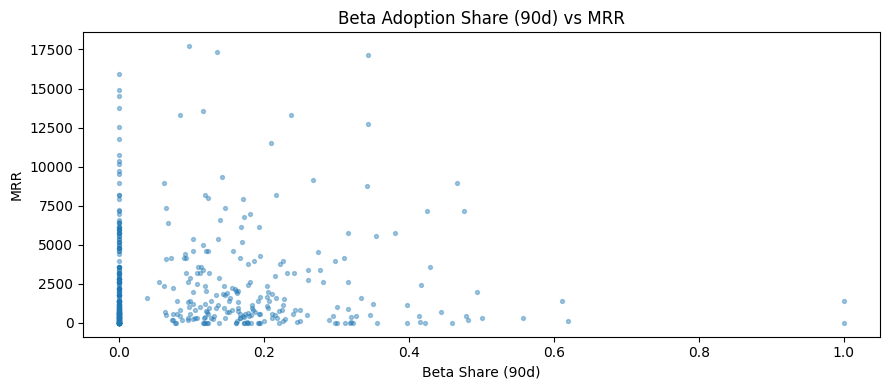

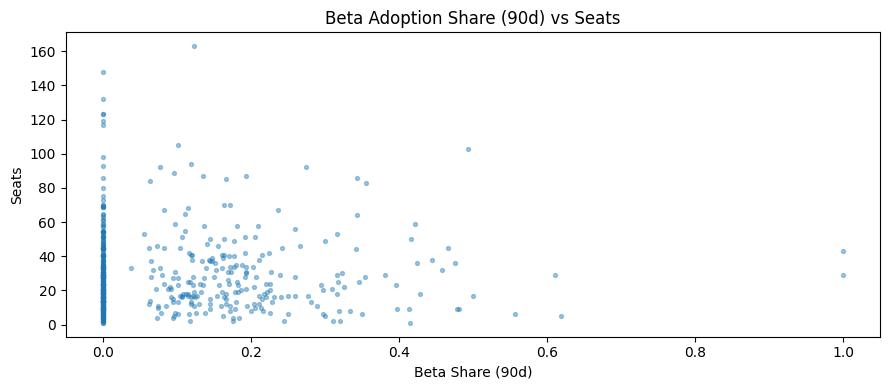

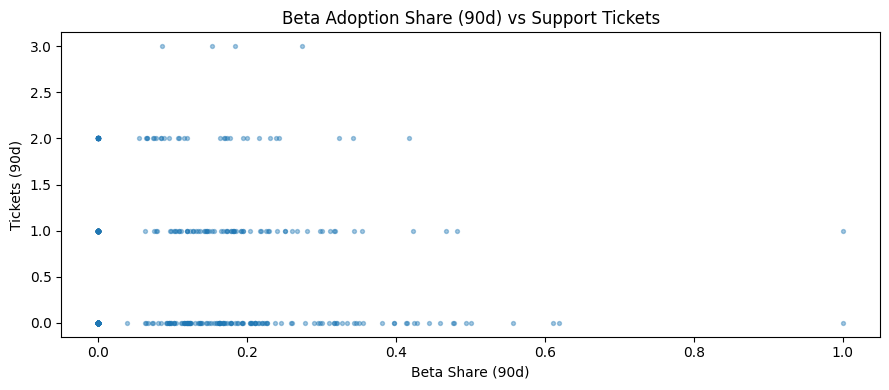

In [10]:
# Beta Share vs MRR
plt.figure(figsize=(9,4))
plt.scatter(df["beta_share_90d"], df["mrr_amount"], s=8, alpha=0.4)
plt.title("Beta Adoption Share (90d) vs MRR")
plt.xlabel("Beta Share (90d)")
plt.ylabel("MRR")
plt.tight_layout()
plt.savefig("beta_vs_mrr.png", dpi=300) 
plt.show()

# Beta Share vs Seats
plt.figure(figsize=(9,4))
plt.scatter(df["beta_share_90d"], df["seats"], s=8, alpha=0.4)
plt.title("Beta Adoption Share (90d) vs Seats")
plt.xlabel("Beta Share (90d)")
plt.ylabel("Seats")
plt.tight_layout()
plt.savefig("beta_vs_seats.png", dpi=300)  
plt.show()

# Beta Share vs Tickets
plt.figure(figsize=(9,4))
plt.scatter(df["beta_share_90d"], df["tickets"], s=8, alpha=0.4)
plt.title("Beta Adoption Share (90d) vs Support Tickets")
plt.xlabel("Beta Share (90d)")
plt.ylabel("Tickets (90d)")
plt.tight_layout()
plt.savefig("beta_vs_tickets.png", dpi=300)  
plt.show()

